[View in Colaboratory](https://colab.research.google.com/github/pgunnink/HisparcML/blob/master/Example%20Jupyter%20Notebook.ipynb)

Template with several analysis options



# Install dependecies and load data from Nikhef servers

In [0]:
#!kill -9 -1 # uncomment this line to completely reboot the VM running this notebook, in case stuff starts to hang or something

Eerst moeten er even dingen worden geïnstalleerd. `HisparcML` bevat de code om met de simulatiedata te werken, `process_kascade` is voor de Kascade data.  

In [1]:
# random installation stuff
!pip uninstall -y HisparcML >> /dev/null
!pip install git+https://github.com/pgunnink/HisparcML.git >> /dev/null
!pip install tables >> /dev/null 
!pip install hisparc-sapphire >> /dev/null
!rm -r ./process_kascade
!git clone https://github.com/pgunnink/process_kascade
!pip install tqdm


Skipping HisparcML as it is not installed.
rm: cannot remove './process_kascade': No such file or directory
Cloning into 'process_kascade'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


In [0]:
import matplotlib as mpl
mpl.style.use('default')
import sys
from keras.engine.topology import Layer
import scipy.stats as stats
from keras.models import Sequential
from keras.utils import HDF5Matrix
import h5py
from HisparcML.DegRad import *
from HisparcML.ProcessData import read_sapphire_simulation
from keras.layers import Conv2D, Input, Reshape, concatenate, Conv1D, Flatten, \
    Dense, PReLU, LSTM, Conv3D, SeparableConv2D, ELU, SeparableConv1D, Dropout, \
    BatchNormalization, LocallyConnected2D, MaxPooling2D, GlobalAveragePooling2D, \
    GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, Adamax, Nadam, RMSprop, Adadelta
from keras.callbacks import TensorBoard,ReduceLROnPlateau,EarlyStopping
from HisparcML.CustomMetrics import metric_degrees_difference
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import importlib
from process_kascade.ProcessData import process_kascade
from tqdm import tqdm_notebook, tqdm
from scipy import stats

Download data van de Hisparc servers (ik heb gewoon symlinks gemaakt vanuit /data/hisparc naar ~/public_html)

In [0]:
data_file = "main_data_kascade.h5"
kascade_file = "kascade.h5"
kascade_output = 'k_data.h5'
N_stations = 1
sim_output = 'simulated.h5'


In [9]:
!rm {data_file}
!wget https://www.nikhef.nl/~pgunnink/Kascade/{data_file}

rm: cannot remove 'main_data_kascade.h5': No such file or directory

Redirecting output to ‘wget-log’.


In [10]:
!rm {kascade_file}
!wget https://www.nikhef.nl/~pgunnink/Kascade/{kascade_file}

rm: cannot remove 'kascade.h5': No such file or directory

Redirecting output to ‘wget-log.1’.


# Process Data

Dit is de preprocessing van de data. 

100% (49783 of 49783) |##################| Elapsed Time: 0:02:55 Time:  0:02:55


Std of integrals: 0.3953438575465891
Std of timings: 236.11724875595905


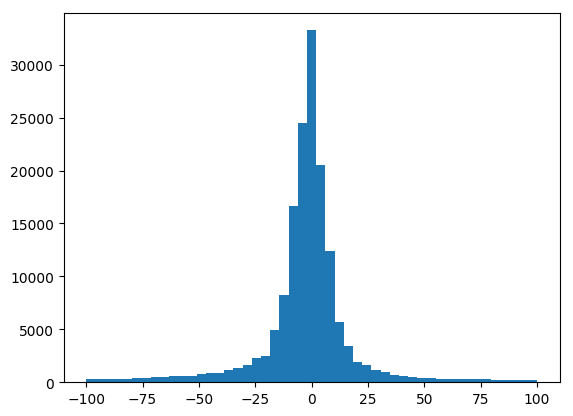

In [12]:
process_kascade(kascade_file, kascade_output, std_timings=10.26)


Hier kun je nog wat dingen aanpassen, zoals energie en triggers. Let op dat je wel traces opslaat, maar dat je die dus niet moet hebben, want je gaat vanuit de photontimes nog een keer traces maken.

  5%|▌         | 22628/446742 [00:00<00:17, 24781.42it/s]

Writing chunk 1


  9%|▉         | 42058/446742 [00:01<00:16, 24188.17it/s]

Writing chunk 2


 13%|█▎        | 58838/446742 [00:02<00:15, 24467.77it/s]

Writing chunk 3


 18%|█▊        | 78549/446742 [00:03<00:15, 24525.68it/s]

Writing chunk 4


 21%|██▏       | 95356/446742 [00:03<00:17, 20224.69it/s]

Writing chunk 5


 26%|██▌       | 115191/446742 [00:04<00:13, 23921.40it/s]

Writing chunk 6


 30%|██▉       | 133901/446742 [00:05<00:13, 23238.10it/s]

Writing chunk 7


 34%|███▍      | 153530/446742 [00:06<00:12, 23850.69it/s]

Writing chunk 8


 38%|███▊      | 170867/446742 [00:06<00:10, 25136.47it/s]

Writing chunk 9


 42%|████▏     | 188421/446742 [00:07<00:13, 19703.74it/s]

Writing chunk 10


 47%|████▋     | 208578/446742 [00:08<00:10, 23812.35it/s]

Writing chunk 11


 51%|█████     | 227617/446742 [00:09<00:09, 23508.26it/s]

Writing chunk 12


 55%|█████▌    | 246975/446742 [00:09<00:08, 23654.41it/s]

Writing chunk 13


 60%|█████▉    | 266505/446742 [00:10<00:07, 24256.41it/s]

Writing chunk 14


 63%|██████▎   | 283051/446742 [00:11<00:07, 22321.19it/s]

Writing chunk 15


 68%|██████▊   | 302826/446742 [00:12<00:06, 22619.02it/s]

Writing chunk 16


 72%|███████▏  | 319465/446742 [00:12<00:06, 20588.29it/s]

Writing chunk 17


 77%|███████▋  | 342094/446742 [00:13<00:04, 21504.91it/s]

Writing chunk 18


 80%|████████  | 358269/446742 [00:14<00:03, 23250.14it/s]

Writing chunk 19


 85%|████████▍ | 377764/446742 [00:15<00:02, 23776.64it/s]

Writing chunk 20


 88%|████████▊ | 395046/446742 [00:15<00:02, 23527.05it/s]

Writing chunk 21


 93%|█████████▎| 414353/446742 [00:16<00:01, 23873.39it/s]

Writing chunk 22


 97%|█████████▋| 433944/446742 [00:17<00:00, 21924.82it/s]

Writing chunk 23


100%|██████████| 446742/446742 [00:17<00:00, 24969.69it/s]


Filling datasets 19.229778357000214
Out of 446742 items 239143 remained
mpv 134.44286559951084
Finding MiP 19.67807916000038
Std of integrals: 0.5496769
Creating total_traces 22.891313362000346
Std of timings: 10.363027
Normalizing input_features 23.433466517000397
Shuffling everything 30.78461354199999


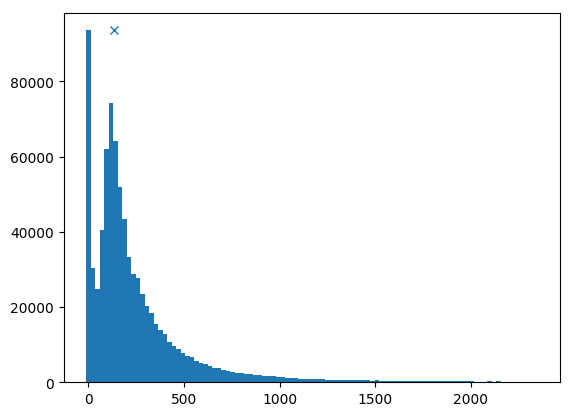

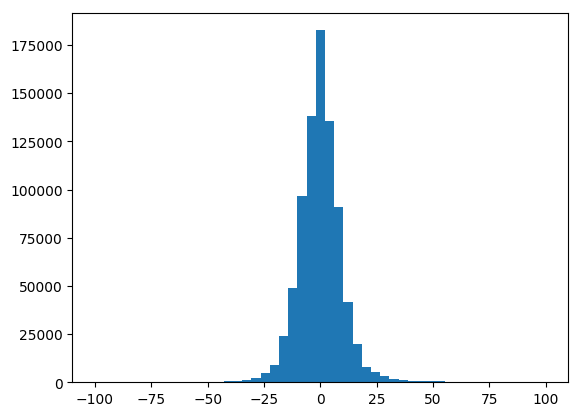

In [14]:
ENERGY_LOW = .9*10**14.5
ENERGY_LOW = 0
ENERGY_HIGH = 11**17
read_sapphire_simulation(data_file, sim_output, N_stations,
                             find_mips=True, uniform_dist=False, 
                             no_gamma_peak=False, trigger=3, trigger_max=4, energy_low=ENERGY_LOW, 
                             energy_high=ENERGY_HIGH, verbose=True,
                             max_samples=1, CHUNK_SIZE=10**4, rossi_dist=False, skip_nonreconstructed=False, photontimes=True)

In [0]:
class PreProcPMT(Layer):
    def __init__(self, **kwargs):
        """
        Dit is dezelfde code als in PMT_tf.py uit HisparcML, alleen die uit PMT_tf.py is beter opgeruimd... 
        """
        self.GR = [10., 2.]
        self.tau = np.array([7.419741616764922, 1.5])
        #self.tau = np.array([7.419741616764922, 0.0001])
        self.sigma = np.array([0.8, .06])
        #self.sigma = np.array([0.39, .00001])*1.7
        
        self.chance_1 = 0.75

        self.scale_1 = np.array([28.3/290., 10.6/290.]) # mean, std, as percentage of main peak size
        self.loc_1 = np.array([21, 7]) 
        
        self.chance_2 = 0.3

        self.scale_2 = np.array([9./88., 6./88.])  # mean, std, as percentage of main peak size
        self.loc_2 = np.array([32, 10]) 
        

        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.timings = tf.constant(np.arange(1.25, 80*2.5+1.25, 2.5), 
                                  dtype='float32', 
                                  shape=(80,), 
                                  name='timings_25_ns')
        super().build(input_shape)
    
    def call(self, x):
        x = tf.reshape(x, [-1,80])
        batch_size = tf.shape(x)
        #gain = tf.random_normal(batch_size, mean=self.GR[0], stddev=self.GR[1])
        #t_x_scaled = tf.random_normal(batch_size, mean=self.tau[0], stddev=self.tau[1])/200

        #ln = tf.log(self.timings/t_x_scaled)
        #sigma = tf.random_normal(batch_size, mean=self.sigma[0], stddev=self.sigma[1])
        #exp_scaled = tf.exp(-0.5*(ln/sigma)**2)
        #exp_scaled = tf.expand_dims(exp_scaled, 0)
        #exp_scaled = tf.tile(exp_scaled, (tf.shape(x)[0],1))

        #total_constant_part = gain*exp_scaled

        to_return = tf.zeros_like(x, dtype='float32')

        x = tf.random_poisson(x*.25, [1])
        x = x[0,:,:]

        #shift_x = tf.random_poisson(x*self.afterpulse_chance, [1])
        #shift_x = shift_x[0,:,:]
        #shift_x = tf.to_int32(tf.round(shift_x))

        def smear(traces, shift_mean, shift_std):
            new_photontimes = np.zeros(traces.shape, dtype='float32')
            for i, row in enumerate(traces):
                for i_x, q in enumerate(row):
                    for n in range(int(q)):
                        shift = np.random.normal(shift_mean, shift_std)+i_x
                        shift = int(shift)
                        new_photontimes[i, shift] += 1
            return new_photontimes

        #shifted_photontimes = tf.py_func(smear, [shift_x, self.shift, self.shift_std], tf.float32)
        #x = x + shifted_photontimes

        i = tf.constant(0, dtype='int32')
        condition = lambda i, x, exp_scaled: tf.less(i, 80)
        loop_vars = [i, x, to_return]
        
        gain = tf.truncated_normal((batch_size[0],), mean=self.GR[0], stddev=self.GR[1])
        gain = tf.expand_dims(gain, 0)
        gain = tf.transpose(tf.tile(gain, (80,1)))
        tau = tf.truncated_normal((batch_size[0],), mean=self.tau[0], stddev=self.tau[1])
        t_x_scaled = tau
        t_x_scaled = tf.expand_dims(t_x_scaled, 0)
        t_x_scaled = tf.transpose(tf.tile(t_x_scaled, (80,1)))

        ln = tf.log(self.timings/t_x_scaled)
        
        sigma = tf.truncated_normal((batch_size[0],), mean=self.sigma[0], stddev=self.sigma[1])
        sigma = tf.expand_dims(sigma, 0)
        sigma = tf.transpose(tf.tile(sigma, (80,1)))
        exp_scaled = tf.exp(-0.5*(ln/sigma)**2)
        
        total_constant_part = gain*exp_scaled
        def single_run_loop(i, x, to_return):
            temp_x = tf.expand_dims(x[:,i],0)
            temp_x = tf.tile(temp_x, (80,1))
            temp_x = tf.transpose(temp_x)
            result = temp_x * total_constant_part

            paddings = tf.stack((tf.zeros(2, dtype='int32'),tf.stack((i, tf.constant(0, dtype='int32')))))
            result = tf.pad(result, paddings, "CONSTANT")
            to_return = to_return + result[:, :80]
            i = i + 1
            return i, x, to_return

        _, _, res = tf.while_loop(condition, single_run_loop, loop_vars)
        
        def add_afterpulses(traces, chance, pos, scale, tau, sigma):
            def first_rise(t):
                for i, x in enumerate(t):
                    if x > 0:
                        return i
                else:
                    return None
                    
            def f(t, b, tau, sigma):
                res = np.zeros(t.shape)
                t_calc = t[t>b]
                res[t>b] = np.exp(-.5*(np.log((t_calc-b)/tau)/sigma)**2)
                return res
                
            def truncated_normal(mean, std):
                a, b = (mean-2*std - mean) / std, (mean+2*std - mean) / std
                x = stats.truncnorm(a, b, loc=mean, scale=std)
                return x.rvs()

            
            new_traces = traces
            for i, t in enumerate(traces):
                if np.random.random_sample() < chance:
                    beginning = first_rise(t)
                    if beginning is not None:
                        b_loc = truncated_normal(*pos) + beginning*2.5
                        tau_loc = truncated_normal(*tau)
                        sigma_loc = truncated_normal(*sigma)
                        scale_loc = truncated_normal(*scale)
                        
                        a = f(np.linspace(1.25, 80*2.5+1.25, 80), b_loc, tau_loc, sigma_loc)
                        t += scale_loc*np.max(t)*a
                            
                        new_traces[i, :] = t
            return new_traces
                    
              
        res_2 = tf.py_func(add_afterpulses, [res, self.chance_1, self.loc_1, self.scale_1, self.tau, self.sigma], tf.float32)
        
        #res_3 = tf.py_func(add_afterpulses, [res, self.chance_2, self.loc_2, self.scale_2, self.tau, self.sigma], tf.float32)
        final_res = res_2 + tf.random_normal(tf.shape(res),0,1.8)
        
        
        return tf.reshape(final_res, [-1,4,80])
        
    def compute_output_shape(self, input_shape):
        return input_shape

Lees nu de data in met `HDF5Matrix`, dat is een wrapper van Keras die direct een h5py dataset inleest en kan gebruiken als input. Ook zet ik de cartesische coordinaten om in zenith en azimuth voor later

In [0]:
with h5py.File(sim_output, 'r') as f:
    length_dataset = f['traces'].len() # assuming everything is the same length
    f.close()


sample_split = int(length_dataset*0.9)
photontimes_test = HDF5Matrix(sim_output, 'photontimes', start=sample_split+1, end=length_dataset )

labels_test = HDF5Matrix(sim_output, 'labels', start=sample_split+1, end=length_dataset)
traces_train = HDF5Matrix(sim_output, 'traces', start=0, end=sample_split)
labels_train = HDF5Matrix(sim_output, 'labels', start=0, end=sample_split)
photontimes_train = HDF5Matrix(sim_output, 'photontimes', start=0, end=sample_split)
input_features_train = HDF5Matrix(sim_output, 'input_features', start=0, end=sample_split)
mips_test = HDF5Matrix(sim_output, 'mips', start=sample_split+1, end=length_dataset)
rec_z_test = HDF5Matrix(sim_output, 'rec_z', start=sample_split+1, end=length_dataset)
rec_a_test = HDF5Matrix(sim_output, 'rec_a', start=sample_split+1, end=length_dataset)

energies_test = HDF5Matrix(sim_output, 'energies', start=sample_split+1, end=length_dataset)
energies_train = HDF5Matrix(sim_output, 'energies', start=0, end=sample_split)

c_distance_test = HDF5Matrix(sim_output, 'core_distance', start=sample_split+1, end=length_dataset)
c_distance_train = HDF5Matrix(sim_output, 'core_distance', start=0, end=sample_split)


# process sapphire angles to cartesion
x_rec,y_rec,z_rec = azimuth_zenith_to_cartestian(rec_z_test[:],rec_a_test[:])
sapphire_reconstruction = np.concatenate((x_rec.reshape(-1,1),y_rec.reshape(-1,1),z_rec.reshape(-1,1)),axis=1)

N_detectors = N_stations*4
length_trace = 80
features = 2

In [0]:
z_sapphire, a_sapphire = cartestian_to_azimuth_zenith(sapphire_reconstruction[:,0], sapphire_reconstruction[:,1], sapphire_reconstruction[:,2])


# Processing Kascade Files

Lees Kascade in

In [0]:
kascade_traces = HDF5Matrix(kascade_output, 'traces')
kascade_input_features = HDF5Matrix(kascade_output, 'input_features')
kascade_labels = HDF5Matrix(kascade_output, 'labels')
kascade_zenith = HDF5Matrix(kascade_output, 'zenith')
kascade_azimuth = HDF5Matrix(kascade_output, 'azimuth')
kascade_zenith_rec = HDF5Matrix(kascade_output, 'rec_z')
kascade_azimuth_rec = HDF5Matrix(kascade_output, 'rec_a')

x_rec,y_rec,z_rec = azimuth_zenith_to_cartestian(kascade_zenith_rec[:],kascade_azimuth_rec[:])
kascade_sapphire_reconstruction = np.concatenate((x_rec.reshape(-1,1),y_rec.reshape(-1,1),z_rec.reshape(-1,1)),axis=1)

Creeer de traces (dit duurt dus ongeveer 25 minuten voor 200,000 events)

In [0]:
from keras.models import Sequential

determine_mip = Sequential([
    PreProcPMT(input_shape=(4,80))
])
print(photontimes_train[:].shape)
traces_train = determine_mip.predict(photontimes_train, verbose=1, batch_size=2**8)
traces_test = determine_mip.predict(photontimes_test, verbose=1, batch_size=2**8)

(215228, 4, 80)
 22016/215228 [==>...........................] - ETA: 25:46

In [0]:
def first_rise(t, treshold=30):
  for i, x in enumerate(t):
    if x > treshold:
      return i

Lees de nieuwe timings in en reken de pulseintegraal uit

In [0]:
def generate_features(traces):
  timings = np.zeros(traces.shape[0:2])
  for i, station in enumerate(tqdm(traces)):
    for j, t in enumerate(station):
      t0 = first_rise(t, treshold=30)
      if t0 is None:
        #traces_unscaled[i,j,:] = 0
        timings[i,j] = np.nan
      else:
        timings[i,j] = t0*2.5
  timings -= np.nanmean(timings,axis=1)[:,np.newaxis]
  print('Std of timings: %s' % np.nanstd(timings))
  timings /= np.nanstd(timings)
  timings[np.isnan(timings)] = 0.

  total_traces = np.sum(np.abs(traces[:]) / 281, axis=2)
  total_traces = np.log10(total_traces+1)
  total_traces -= np.mean(total_traces, axis=1)[:, np.newaxis]
  print("Std of integrals: %s" % np.std(total_traces))
  total_traces /= np.std(total_traces)

  input_features = np.stack((timings,total_traces),axis=2)
  return input_features

Schaal de traces met de MIP-peak en pak de log-transform

  0%|          | 358/215228 [00:00<01:00, 3573.78it/s]

Std of timings: 8.502426453047834
Std of integrals: 0.490379


100%|██████████| 215228/215228 [00:46<00:00, 4608.04it/s]


Std of timings: 8.549423909701067
Std of integrals: 0.49124208
318.1818181818182


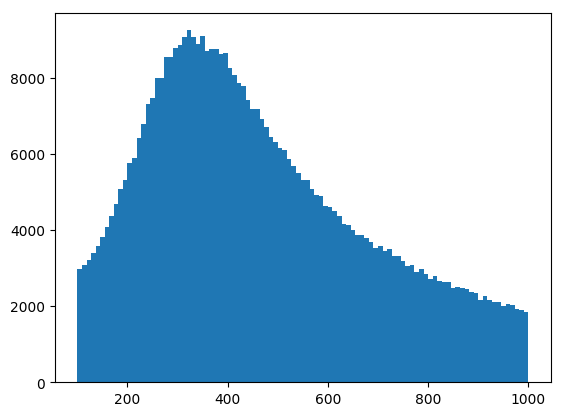

In [28]:
input_features_test = generate_features(traces_test)
input_features_train = generate_features(traces_train)
h,bins,_ = plt.hist(np.max(traces_train.reshape((-1,80)), axis=1), bins=np.linspace(100,1000,100))
mip_peak = bins[np.argmax(h)]
print(mip_peak)
traces_train = np.log10(traces_train/mip_peak+1)
traces_test = np.log10(traces_test/mip_peak+1)


rec_z_train = HDF5Matrix(sim_output, 'rec_z', start=0, end=sample_split)
rec_a_train = HDF5Matrix(sim_output, 'rec_a', start=0, end=sample_split)

x_rec,y_rec,z_rec = azimuth_zenith_to_cartestian(rec_z_train[:],rec_a_train[:])
sapphire_reconstruction_train = np.concatenate((x_rec.reshape(-1,1),y_rec.reshape(-1,1),z_rec.reshape(-1,1)),axis=1)

# Training model

Dit is het model dat ik gebruik, dit staat ook in `KerasModel`.py in `HisparcML`

In [0]:
from keras.layers import Permute, MaxPooling2D, LocallyConnected2D, AveragePooling2D, GlobalAveragePooling2D
def baseModelComplicated():
    '''
    The basic model as described by https://arxiv.org/pdf/1708.00647.pdf, but flattened
    out
    '''
    N_stations = 1
    input_traces = Input(shape=(N_stations * 4, length_trace), dtype='float32',
                         name='trace_input')
    reshape_traces = Reshape((N_stations * 4, length_trace, 1))(input_traces)
    input_metadata = Input(shape=(N_stations * 4, features), dtype='float32',
                           name='metadata_input')


    Trace_1 = Conv2D(64, (1, 3), strides=(1, 2), padding='valid',
                   activation='relu', data_format='channels_last',
                   kernel_initializer='he_normal')(reshape_traces)
    Trace_1 = Conv2D(128, (1, 3), strides=(1, 2), padding='valid',
                   activation='relu', data_format='channels_last',
                   kernel_initializer='he_normal')(Trace_1)
    Trace_1_conv = Conv2D(128, (1, 3), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(Trace_1)
    MaxPool1 = MaxPooling2D(pool_size=(1, 3), strides=(1,1), padding='valid')(Trace_1)
    
    combined = concatenate([MaxPool1, Trace_1_conv])
    
    Trace_1 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined)
    Trace_1 = Conv2D(128, (1, 3), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(Trace_1)
    
    Trace_2 = Conv2D(32, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined)
    Trace_2 = Conv2D(64, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(Trace_2)
    Trace_2 = Conv2D(128, (1, 3), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(Trace_2)
    
    combined_2 = concatenate([Trace_1, Trace_2])
    MaxPool2 = MaxPooling2D(pool_size=(1, 3), strides=(1,1))(combined_2)
    Trace_3 = Conv2D(64, (1, 3), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined_2)
    combined_3 = concatenate([MaxPool2, Trace_3])
    
    
    avg_pooling = AveragePooling2D(pool_size=(1, 3), strides=(1,1), padding='same')(combined_3)
    avg_pooling = Conv2D(64, (1, 1), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(avg_pooling)
    
    path_1 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined_3)
    
    path_2 = Conv2D(100, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined_3)
    path_2 = Conv2D(55, (1, 3), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_2)
    
    path_3 = Conv2D(32, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(combined_3)
    path_3 = Conv2D(45, (1, 3), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    path_3 = Conv2D(80, (1, 3), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    
    result = concatenate([path_1, path_2, path_3, avg_pooling])
    """
    maxpool1 = MaxPooling2D(pool_size=(1,3), strides=(1,2))(result)
    conv_1 = Conv2D(32, (1, 3), strides=(1, 2), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    block_1 = Conv2D(80, (1, 1), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(result)
    block_1 = Conv2D(40, (1, 3), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(block_1)
    block_1 = Conv2D(32, (1, 3), strides=(1, 2), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(block_1)
    
    result = concatenate([maxpool1, conv_1, block_1])
    
    avg_pooling = AveragePooling2D(pool_size=(1, 3), strides=(1,1), padding='same')(result)
    avg_pooling = Conv2D(64, (1, 1), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(avg_pooling)
    
    
    
    path_1 = Conv2D(128, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    
    path_2 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    path_2 = Conv2D(128, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_2)
    
    path_3 = Conv2D(20, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    path_3 = Conv2D(30, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    path_3 = Conv2D(100, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    
    result = concatenate([path_1, path_2, path_3, avg_pooling])
    
    path_1 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    
    path_2 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    path_2 = Conv2D(128, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_2)
    
    path_3 = Conv2D(32, (1, 1), strides=(1, 1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    path_3 = Conv2D(64, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    path_3 = Conv2D(80, (1, 7), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(path_3)
    avg_pooling = AveragePooling2D(pool_size=(1, 3), strides=(1,1), padding='same')(result)
    avg_pooling = Conv2D(64, (1, 1), strides=(1, 1), padding='same',
                   activation='relu', kernel_initializer='he_normal')(avg_pooling)
    result = concatenate([path_1, path_2, path_3, avg_pooling])
    result = Conv2D(10, (1,1), strides=(1,1), padding='valid',
                   activation='relu', kernel_initializer='he_normal')(result)
    result = AveragePooling2D(pool_size=(1, 14))(result)
    """
    TraceResult = Reshape((4, -1))(result)
    input_labels = Input(shape=(3,), dtype='float32')
    x = concatenate([TraceResult, input_metadata])
    
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, kernel_initializer='he_normal', activation='relu')(x)
    x = Dense(50, kernel_initializer='he_normal', activation='relu')(x)
    
    #x = Flatten()(x)
    
    
    
    #x = concatenate([input_labels, x])
    Output = Dense(3)(x)
    
    model = Model(inputs=[input_traces, input_metadata], outputs=Output)

    
    A = Adam(lr=0.001)
    model.compile(optimizer=A, loss='mse', metrics=[metric_degrees_difference])

    return model
model = baseModelComplicated()
model.summary()

Dit is de daadwerkelijke training

Er zijn twee lijnen gecomment, deze kun je gebruiken om core distance en energie mee te trainen.



In [33]:
from keras.optimizers import *
from keras.callbacks import LearningRateScheduler

def new_lr(epoch, lr):
  return 0.95*lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=0)

# 





EPOCHS = 50

# Dit is voor richting reconstructie
model.fit([traces_train[:], input_features_train[:]], labels_train[:], batch_size = 2**8, callbacks=[LearningRateScheduler(new_lr, verbose=1), early_stop], verbose=1, epochs=EPOCHS, shuffle='batch', validation_split = 0.1)

# dit is voor core distance
#model.fit([traces_train[:][idx], input_features_train[:], c_distance_train[:], batch_size = 2**8, callbacks=[LearningRateScheduler(new_lr, verbose=1), early_stop], verbose=1, epochs=EPOCHS, shuffle='batch', validation_split = 0.1)

# dit is voor energie reconstructie
#model.fit([traces_train[:], input_features_train[:]], np.log10(energies_train[:]), batch_size = 2**8, callbacks=[LearningRateScheduler(new_lr, verbose=1), early_stop], verbose=1, epochs=EPOCHS, shuffle='batch', validation_split = 0.1)

Train on 193705 samples, validate on 21523 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009500000451225787.
193705/193705 [==============================] - 61s 315us/step - loss: 0.0363 - metric_degrees_difference: 16.1838 - val_loss: 0.0308 - val_metric_degrees_difference: 15.1583
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009025000152178108.
193705/193705 [==============================] - 58s 301us/step - loss: 0.0311 - metric_degrees_difference: 15.2077 - val_loss: 0.0301 - val_metric_degrees_difference: 15.0056
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008573750033974647.
193705/193705 [==============================] - 58s 299us/step - loss: 0.0305 - metric_degrees_difference: 15.0353 - val_loss: 0.0301 - val_metric_degrees_difference: 15.0003
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008145062311086804.
193705/193705 [======================

Doe de voorspelling op de test set (alles heeft hier een `[idx]`, omdat je dan makkelijk alleen de events kan selecteren waar Sapphire kon reconstrueren, maar als je alles wilt hebben moet je dus even `idx = np.ones(len(traces_test), dtype=bool)` doen)

In [34]:
idx = np.ones(len(traces_test), dtype=bool)
model_prediction = model.predict([traces_test[idx], input_features_test[idx]], batch_size=2**12, verbose=1)


23914/23914 [==============================] - 4s 151us/step


Deze code heeft alleen zin als je core distance of energie hebt voorspelt

In [0]:
res = model_prediction[:,0]-c_distance_test[:]
#res = model_prediction[:,0]-np.log10(energies_test[:])
print(np.std(res))
plt.hist(res, histtype='step', label='prediction')
#random_res = model_prediction[:,0] - np.random.permutation(np.log10(energies_test[:]))
random_res = model_prediction[:,0] - np.random.permutation(c_distance_test[:])
print(np.std(random_res))
plt.hist(random_res, histtype='step', label='random')
plt.legend()

Vanaf nu is het alleen voor richting reconstructie. Eigenlijk is de code nu 1 grote chaos en ik denk niet dat je er heel veel aan hebt :) Het is alleen maar plaatjes maken vanaf nu. Wat misschien nog interessant is hoe je die error terugschaalt, dat deed ik met: `dist/(2*np.pi*(np.sin(bins)))`, met `dist` en `bins` gewoon de outputs van een `np.histogram` van de fout.  

Verder maakt de code vanaf nu vooral plotjes, dat kan je denk ik zelf ook wel :)

In [0]:
ev = model.evaluate([traces_test, input_features_test, sapphire_reconstruction],labels_test, batch_size=2**12)
print('Model with trace information, test set: loss: %.4f, mean angle of error: %.4f' % (ev[0],ev[1]))

In [0]:
idx = energies_test[:] > .9*10**14.5
idx = np.ones(len(traces_test), dtype=bool)

model_prediction = model.predict([traces_test[idx], input_features_test[idx]], batch_size=2**12, verbose=1)
z,a = cartestian_to_azimuth_zenith(model_prediction[:,0],model_prediction[:,1],model_prediction[:,2])
actual_direction = labels_test[:]
z_true, a_true = cartestian_to_azimuth_zenith(labels_test[:][:,0],labels_test[:][:,1],labels_test[:][:,2])

Deze alleen runnen als je Kascade voorspellingen wilt doen

In [0]:
ev = model.evaluate([kascade_traces[:], kascade_input_features[:]], kascade_labels[:], batch_size=2**12)
print('With Kascade data: loss: %.4f, mean angle of error: %.4f' % (ev[0],ev[1]))

kascade_prediction = model.predict([kascade_traces[:], kascade_input_features[:]], batch_size=2**8, verbose=1)

In [0]:
zenith,azimuth = cartestian_to_azimuth_zenith(model_prediction[:,0],model_prediction[:,1],model_prediction[:,2])
idx = ~np.isnan(sapphire_reconstruction[:,0])
actual_direction = labels_test[:][idx]

In [0]:
plt.figure()
bins = np.degrees(np.linspace(-.2 * np.pi, .2 * np.pi, 30))
std_nn = np.std(np.degrees(z_true - zenith))
std_sapphire = np.std(np.degrees(z_true - z_sapphire))
h = plt.hist(np.degrees(z_true - z), bins=bins, histtype='step', label=r'Neural network', linewidth=1.5, density=True)
#h = plt.hist(np.extract(~np.isnan(z_sapphire),np.degrees(z_true - z_sapphire)), bins=bins, histtype='step', label=r'Sapphire', linewidth=1.5, density=True)
#plt.legend()
plt.xlabel(r'$\theta_{sim} - \theta_{NN}$') # wat moet hier staan?
plt.ylabel('Occurence')
plt.show()
#plt.savefig('difference_zenith.pdf')

plt.figure()
bins = np.degrees(np.linspace(-np.pi, np.pi, 30))
h = plt.hist(np.degrees(a_true - azimuth), bins=bins, histtype='step', label=r'Neural network', linewidth=1.5, density=True)
#print(np.std(np.degrees(a_true - azimuth)))
#h = plt.hist(np.extract(~np.isnan(z_sapphire),np.degrees(z_true - z_sapphire)), bins=bins, histtype='step', label=r'Sapphire', linewidth=1.5, density=True)
#plt.legend()
plt.xlabel(r'$\phi_{sim} - \phi_{NN}$') # wat moet hier staan?
plt.ylabel('Occurence')
plt.show()
#plt.savefig('difference_zenith.pdf')



In [0]:
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]

plt.figure()
bins = np.linspace(0., 90., 30, dtype=np.float32)
sim_zenith = np.linspace(0.,60.+30,int(17+17/60*30), dtype=np.float32)
sim_zenith -= 0.5
sim_zenith = np.append(sim_zenith, sim_zenith[-1]+1)

h = plt.hist(np.degrees(z_true), bins=sim_zenith, histtype='step', linewidth=1.5, label=r'Simulated')
plt.xlabel(r'$\theta$')
plt.ylabel('Occurence')
plt.savefig('zenith_true_distribution.pdf')
#plt.figure()

h = plt.hist(np.degrees(zenith), bins=sim_zenith, histtype='step', linewidth=1.5, label=r'Neural network')
#plt.xlabel(r'$\theta_{NN}$')
#plt.ylabel('Occurence')
plt.savefig('zenith_nn_distribution.pdf')
plt.legend()

plt.figure()
h = plt.hist(np.extract(~np.isnan(z_sapphire),np.degrees(z_sapphire)), bins=sim_zenith, histtype='step', linewidth=1.5)
plt.xlabel(r'$\theta_{Sapphire}$')
plt.ylabel('Occurence')
plt.savefig('zenith_sapphire_distribution.pdf')

# allemaal code voor als je het in 1 wilt, maar dat ziet er niet uit...
plt.figure()
h = plt.hist(np.degrees(z_true), bins=sim_zenith, histtype='step', linewidth=1.5, label='Simulated', color='red')
h = plt.hist(np.degrees(zenith), bins=sim_zenith, label='Neural network', histtype='step', linewidth=1.5, color='blue')
h = plt.hist(np.extract(~np.isnan(z_sapphire), np.degrees(z_sapphire)), bins=sim_zenith, label='Sapphire', histtype='step', linewidth=1.5, color='green')



#plt.figure()
#h = plt.hist(((np.degrees(z_true), np.degrees(zenith), np.degrees(z_sapphire))), bins=bins, histtype='bar', linewidth=1.5, label=['Simulated', 'Neural network', 'Sapphire'])
#plt.legend()

plt.figure()

h, bins = np.histogram(np.degrees(zenith), bins=bins)
plt.plot(middle_of_bins(bins), h, 'X-', label='Neural network')
h, bins = np.histogram(np.extract(~np.isnan(z_sapphire), np.degrees(z_sapphire)), bins=bins)
plt.plot(middle_of_bins(bins), h, 'X-', label='Sapphire')
h, bins = np.histogram(np.degrees(z_true), bins=sim_zenith)
plt.plot(middle_of_bins(bins), h, 'X-', label='Simulated')
plt.legend()



In [0]:
bins = np.linspace(-180., 180., 20, dtype=np.float32)
z,a = cartestian_to_azimuth_zenith(model_prediction[:,0],model_prediction[:,1],model_prediction[:,2])
plt.figure()
h_orig, bins, p = plt.hist(np.degrees(a_true), bins=bins, histtype='step', label='Simulated', linewidth=1.5)
h_orig_sapphire, bins = np.histogram(np.compress(~np.isnan(a_sapphire),np.degrees(a_true)), bins=bins)

plt.ylabel('Occurence')


h_nn, bins, p = plt.hist(np.degrees(a), bins=bins, histtype='step', label='Neural network', linewidth=1.5)
plt.xlabel(r'$\phi$')
plt.ylabel('Occurence')
plt.legend()
'''
plt.figure()
h_sapphire, bins, p = plt.hist(np.compress(~np.isnan(a_sapphire),np.degrees(a_sapphire)), bins=bins)
plt.xlabel(r'$\phi_{sapphire}$')
plt.ylabel('Occurence')
plt.show()
plt.savefig('saphire_azimuth_distribution.pdf')

plt.bar(middle_of_bins(bins), h_orig_sapphire-h_sapphire, width=(bins[1]-bins[0])/2, label='Sapphire')
plt.bar(middle_of_bins(bins), h_orig-h_nn, width=(bins[1]-bins[0])/2, label='Neural Network')
plt.legend()
plt.xlabel(r'$\phi$')
plt.ylabel('Occurence difference')
'''

In [0]:
energies = 10**np.arange(13.5, 16.5, 0.5)
bins = np.linspace(-180., 180., 10, dtype=np.float32)
z,a = cartestian_to_azimuth_zenith(model_prediction[:,0],model_prediction[:,1],model_prediction[:,2])

for e in energies:
  idx = (energies_test[:]  < 1.1*e) & (energies_test[:] > .9*e) 
  
  plt.ylabel('Occurence')
  h_nn, bins, p = plt.hist(np.degrees(a[idx]), bins=bins, histtype='step', label='{0:.2f}'.format(np.log10(e)), linewidth=1.5)
  plt.xlabel(r'$\phi$')
  plt.ylabel('Occurence')
plt.legend()

In [0]:
bins = np.linspace(-180., 180., 20, dtype=np.float32)
z,a = cartestian_to_azimuth_zenith(model_prediction[:,0],model_prediction[:,1],model_prediction[:,2])
plt.figure()
h_orig, bins, p = plt.hist(np.degrees(a_true), bins=bins, histtype='step', label='Simulated', linewidth=1.5)
h_orig_sapphire, bins = np.histogram(np.compress(~np.isnan(a_sapphire),np.degrees(a_true)), bins=bins)

plt.ylabel('Occurence')


h_nn, bins, p = plt.hist(np.degrees(a), bins=bins, histtype='step', label='Neural network', linewidth=1.5)
plt.xlabel(r'$\phi$')
plt.ylabel('Occurence')
plt.legend()

In [0]:
def transform_error(dist, bins):
  to_return = dist/(2*np.pi*(np.sin(bins)))
  return to_return
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]
plt.figure()
bins = np.linspace(0, 60, 50)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)
h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
width_bin = b[1]-b[0]
events = np.zeros(int(np.sum(h)))
i = 0
for h_local, bin_local in zip(h,middle_bins):
  events[i:i+int(h_local)] = bin_local
  i += int(h_local)+1
h = h / np.sum(h)
#plt.bar(b[:-1], h, width=width_bin, label='Neural network')
std = np.sqrt(np.mean(abs(events)**2))
print("Standard deviation of neural network: %s" % std)
plt.step(bins, np.insert(h,0,0), label='Neural network')

a = np.compress(~np.isnan(a), a)
h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
events = np.zeros(int(np.sum(h)))
i = 0
for h_local, bin_local in zip(h,middle_bins):
  events[i:i+int(h_local)] = bin_local
  i += int(h_local)+1
std = np.sqrt(np.mean(abs(events)**2))
print("Standard deviation of sapphire: %s" % std)
# sanity check
print(np.count_nonzero(events<std)/np.count_nonzero(events))
h = h / np.sum(h)
#plt.bar(b[:-1], h, width=(b[1]-b[0]), label='Sapphire')
plt.step(bins, np.insert(h,0,0), label='Sapphire')
plt.legend()

In [0]:
def transform_error(dist, bins):
  to_return = dist/(2*np.pi*(np.sin(bins)))
  return to_return
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]

In [0]:
from scipy import stats

def transform_error(dist, bins):
  to_return = dist/(2*np.pi*(np.sin(bins)))
  return to_return
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]


#a = angle_between_two_vectors(np.compress(~np.isnan(sapphire_reconstruction[:,0]), sapphire_reconstruction, axis=0), actual_direction)
#non_reconstructed = np.isnan(a)


bins = np.linspace(0, 60, 30)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)

"""
a = angle_between_two_vectors(model_prediction, actual_direction)



h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))

#plt.bar(b[:-1], h, width=width_bin, label='Neural network')

new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)

mean, var = stats.halfnorm.fit(new_a)
print(mean, var)


h = h / np.sum(h)
fwhm = middle_bins[h<np.max(h)/2][0]
print("fwhm of nn: %s" % fwhm)
plt.step(bins, np.insert(h,0,0), label='Neural network, FWHM: {0:.2f}'.format(fwhm))

"""
idx = energies_test[:] > 0.9*10**14.5
idx = np.ones(len(actual_direction), dtype=bool)
a = angle_between_two_vectors(model_prediction, actual_direction[idx])

h, b = np.histogram(a, bins=bins)
h = transform_error(h, np.radians(middle_bins))

new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)


sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
    
  
  
h = h / np.sum(h)
#plt.bar(b[:-1], h, width=width_bin, label='Neural network')


fwhm = middle_bins[h<np.max(h)/2][0]

print('fwhm of nn with only sapphire reconstructed events %s' % fwhm)

plt.step(bins, np.insert(h,0,0), label='Neural network, 68th percentile: {0:.2f}'.format(sixtyeight))


a = angle_between_two_vectors(sapphire_reconstruction[idx], actual_direction[idx])



print(np.count_nonzero(np.isnan(a)))
print('total: %s' % len(a))
a = np.compress(~np.isnan(a), a)



h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
fwhm = middle_bins[h<np.max(h)/2][0]
print(fwhm)

print("fwhm of sapphire: %s" % fwhm)
new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)


sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
    


# sanity check


h = h / np.sum(h)
#plt.bar(b[:-1], h, width=(b[1]-b[0]), label='Sapphire')
plt.step(bins, np.insert(h,0,0), label='Sapphire, 68th percentile: {0:.2f}'.format(sixtyeight))
plt.legend()
plt.xlabel(r'$\delta (\degree)$')
plt.ylabel(r'$N(\delta)$')



In [0]:
energies = 10**np.arange(13.5, 17, 0.5)



fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []
for e in energies:
  idx = (energies_test[:]  < 1.1*e) & (energies_test[:] > .9*e) 

  bins = np.linspace(0, 40, 200)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  
  new_a = []
  for i, b in enumerate(middle_bins):
    for _ in range(int(h[i])):
      new_a.append(b)

  sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
  h = h / np.sum(h)
  #plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))#'Neural network, FWHM: {0:.2f}'.format(fwhm))
  fwhm_per_zenith.append(sixtyeight)
  fwhm_zeniths.append(np.log10(e))
  fwhm_std.append(sixtyeight/np.sqrt(len(a)))
  print(len(a))
plt.figure()
plt.plot(fwhm_zeniths, fwhm_per_zenith, 'o')
plt.xlabel(r'$\log$ E (Ev)')
plt.ylabel(r'68th percentile $\delta (\degree)$')
plt.grid()

In [0]:
z_true[sorted_zenith[1000]]

0.065449566

In [0]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

#zenith_angles = np.linspace(0, 50, 20)

zenith_angles = np.linspace(0,50,5)
fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []

bins = np.linspace(0, 40, 100)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)

sorted_zenith = np.argsort(z_true)
i_local = 0
idx = []
z_local = []
limit = 2000
print(len(sorted_zenith))
with tqdm(total=len(sorted_zenith)) as t:
  while i_local < len(sorted_zenith):
    z_local.append(z_true[sorted_zenith[i_local]])
    idx.append(sorted_zenith[i_local])
    if len(z_local) == limit:
      t.update(limit)
      a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])
      h, b = np.histogram(a, bins=bins)
      h = transform_error(h,np.radians(middle_bins))
      new_a = []
      for i, b in enumerate(middle_bins):
        for _ in range(int(h[i])):
          new_a.append(b)
      sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
      h = h / np.sum(h)
      fwhm_per_zenith.append(sixtyeight)
      fwhm_zeniths.append(np.mean(z_local))
      idx = []
      z_local = []
    i_local += 1
plt.figure()
plt.plot(np.degrees(fwhm_zeniths), fwhm_per_zenith, 'o')
plt.grid()
plt.xlabel(r'$\theta_{sim} (\degree)$')
plt.ylabel(r'68th percentile $\delta (\degree)$')
"""
for z1, z2 in pairwise(np.radians(zenith_angles)):
  idx = (z_true>=z1) & (z_true < z2)
  bins = np.linspace(0, 40, 100)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  new_a = []
  for i, b in enumerate(middle_bins):
    for _ in range(int(h[i])):
      new_a.append(b)
  if len(new_a) < 500:
    continue
  sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
  h = h / np.sum(h)
  plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))
  fwhm_per_zenith.append(sixtyeight)
  fwhm_zeniths.append(.5*(z2+z1))
  fwhm_std.append(sixtyeight/np.sqrt(len(a)))
  plt.legend()
plt.figure()
plt.plot(np.degrees(fwhm_zeniths), fwhm_per_zenith, 'o')
plt.grid()
plt.xlabel(r'$\theta (\degree)$')
plt.ylabel(r'68th percentile $\delta (\degree)$')
"""

In [0]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

azimuth_angles = np.linspace(-180, 180, 20)
fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []
for z1, z2 in pairwise(np.radians(azimuth_angles)):
  idx = (a_true>=z1) & (a_true < z2)

  bins = np.linspace(0, 40, 100)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  new_a = []
  for i, b in enumerate(middle_bins):
    for _ in range(int(h[i])):
      new_a.append(b)
  if len(new_a) < 500:
    continue
  sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
  h = h / np.sum(h)
  #plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))#'Neural network, FWHM: {0:.2f}'.format(fwhm))
  fwhm_per_zenith.append(sixtyeight)
  fwhm_zeniths.append(.5*(z2+z1))
  fwhm_std.append(sixtyeight/np.sqrt(len(a)))
plt.figure()
plt.plot(np.degrees(fwhm_zeniths), fwhm_per_zenith, 'o-')
plt.grid()
plt.xlabel(r'$\phi (\degree)$')
plt.ylabel(r'68th percentile $\delta (\degree)$')


In [0]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

c_distance = np.linspace(0, 100, 10)


from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

#zenith_angles = np.linspace(0, 50, 20)

zenith_angles = np.linspace(0,50,5)
fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []

bins = np.linspace(0, 40, 100)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)

sorted_zenith = np.argsort(c_distance_test[:])
i_local = 0
idx = []
z_local = []
limit = 4000
print(len(sorted_zenith))
with tqdm(total=len(sorted_zenith)) as t:
  while i_local < len(sorted_zenith):
    z_local.append(c_distance_test[sorted_zenith[i_local]])
    idx.append(sorted_zenith[i_local])
    if len(z_local) == limit:
      t.update(limit)
      a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])
      h, b = np.histogram(a, bins=bins)
      h = transform_error(h,np.radians(middle_bins))
      new_a = []
      for i, b in enumerate(middle_bins):
        for _ in range(int(h[i])):
          new_a.append(b)
      sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
      h = h / np.sum(h)
      fwhm_per_zenith.append(sixtyeight)
      fwhm_zeniths.append(np.mean(z_local))
      idx = []
      z_local = []
    i_local += 1
plt.figure()
plt.plot(fwhm_zeniths, fwhm_per_zenith, 'o')
plt.grid()
plt.xlabel('Core distance (m)')
plt.ylabel(r'68th percentile $\delta (\degree)$')
"""
for z1, z2 in pairwise(np.radians(zenith_angles)):
  idx = (z_true>=z1) & (z_true < z2)
  bins = np.linspace(0, 40, 100)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  new_a = []
  for i, b in enumerate(middle_bins):
    for _ in range(int(h[i])):
      new_a.append(b)
  if len(new_a) < 500:
    continue
  sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
  h = h / np.sum(h)
  plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))
  fwhm_per_zenith.append(sixtyeight)
  fwhm_zeniths.append(.5*(z2+z1))
  fwhm_std.append(sixtyeight/np.sqrt(len(a)))
  plt.legend()
plt.figure()
plt.plot(np.degrees(fwhm_zeniths), fwhm_per_zenith, 'o')
plt.grid()
plt.xlabel(r'$\theta (\degree)$')
plt.ylabel(r'68th percentile $\delta (\degree)$')




fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []
for z1, z2 in pairwise(c_distance):
  idx = (c_distance_test[:]>=z1) & (c_distance_test[:] < z2)

  bins = np.linspace(0, 40, 100)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(model_prediction[idx], actual_direction[idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  new_a = []
  for i, b in enumerate(middle_bins):
    for _ in range(int(h[i])):
      new_a.append(b)
  if len(new_a) < 500:
    continue
  sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]
  h = h / np.sum(h)
  #plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))#'Neural network, FWHM: {0:.2f}'.format(fwhm))
  fwhm_per_zenith.append(sixtyeight)
  fwhm_zeniths.append(.5*(z2+z1))
  fwhm_std.append(sixtyeight/np.sqrt(len(a)))
plt.figure()
plt.plot(fwhm_zeniths, fwhm_per_zenith, 'o')
plt.grid()
plt.xlabel('Core distance (m)')
plt.ylabel(r'68th percentile $\delta (\degree)$')
"""

In [0]:
higher_than_2 = [i for i, q in enumerate(mips_test) if q[0]>2 and q[1]>2 and q[2]>2 and q[3]> 2]
print(len(higher_than_2))
higher_than_2 = np.array(higher_than_2)
def transform_error(dist, bins):
  to_return = dist/(2*np.pi*(np.sin(bins)))
  return to_return
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]
plt.figure()


bins = np.linspace(0, 60, 50)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)
a = angle_between_two_vectors(model_prediction, actual_direction)
a = a[higher_than_2]


h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
h = h / np.sum(h)
#plt.bar(b[:-1], h, width=width_bin, label='Neural network')

fwhm = middle_bins[h<np.max(h)/2][0]
print("fwhm of nn: %s" % fwhm)
plt.step(bins, np.insert(h,0,0), label='Neural network, FWHM: {0:.2f}'.format(fwhm))



a = angle_between_two_vectors(sapphire_reconstruction, actual_direction)
a = a[higher_than_2]

print(np.count_nonzero(np.isnan(a)))
print('total: %s' % len(a))
a = np.compress(~np.isnan(a), a)
h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
fwhm = middle_bins[h<np.max(h)/2][0]
print(fwhm)

print("fwhm of sapphire: %s" % fwhm)


# sanity check
print(np.count_nonzero(events<std)/np.count_nonzero(events))


h = h / np.sum(h)
#plt.bar(b[:-1], h, width=(b[1]-b[0]), label='Sapphire')
plt.step(bins, np.insert(h,0,0), label='Sapphire, FWHM: {0:.2f}'.format(fwhm))
plt.legend()
plt.xlabel(r'$\delta (\degree)$')
plt.ylabel(r'$N(\delta)$')

# Kascade 

In [0]:
kascade_zenith, kascade_azimuth = cartestian_to_azimuth_zenith(kascade_labels[:][:,0], kascade_labels[:][:,1], kascade_labels[:][:,2])
kascade_pred_zenith, kascade_pred_azimuth = cartestian_to_azimuth_zenith(kascade_prediction[:][:,0], kascade_prediction[:][:,1], kascade_prediction[:][:,2])
kascade_sapp_zenith, kascade_sapp_azimuth = cartestian_to_azimuth_zenith(kascade_sapphire_reconstruction[:][:,0], kascade_sapphire_reconstruction[:][:,1], kascade_sapphire_reconstruction[:][:,2])

print('Percentage of not reconstructed events {0:.2f}'.format(np.count_nonzero(np.isnan(kascade_sapp_azimuth))/len(kascade_sapp_azimuth)))

Percentage of not reconstructed events 0.57


In [0]:
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]


plt.figure()
bins = np.linspace(0., 90., 30, dtype=np.float32)

h = plt.hist(np.degrees(kascade_zenith), bins=bins, histtype='step', linewidth=1.5, label=r'Kascade')
plt.xlabel(r'$\theta$')
plt.ylabel('Occurence')
plt.savefig('zenith_true_distribution.pdf')
#plt.figure()

h = plt.hist(np.degrees(kascade_pred_zenith), bins=bins, histtype='step', linewidth=1.5, label=r'Neural network')
#plt.xlabel(r'$\theta_{NN}$')
#plt.ylabel('Occurence')
plt.savefig('zenith_nn_distribution.pdf')

h = plt.hist(np.extract(~np.isnan(kascade_sapp_zenith),np.degrees(kascade_sapp_zenith)), bins=bins, histtype='step', linewidth=1.5, label='Sapphire')
#plt.xlabel(r'$\theta_{Sapphire}$')
#plt.ylabel('Occurence')
#plt.savefig('zenith_sapphire_distribution.pdf')

plt.legend()




In [0]:
bins = np.linspace(-180., 180., 20, dtype=np.float32)
plt.figure()
h_orig, bins, p = plt.hist(np.degrees(kascade_azimuth), bins=bins, histtype='step', label='Kascade', linewidth=1.5)

plt.ylabel('Occurence')


h_nn, bins, p = plt.hist(np.degrees(kascade_pred_azimuth), bins=bins, histtype='step', label='Neural network', linewidth=1.5)
plt.xlabel(r'$\phi$')
plt.ylabel('Occurence')
h_orig_sapphire, bins, _ = plt.hist(np.compress(~np.isnan(kascade_sapp_azimuth),np.degrees(kascade_sapp_azimuth)), bins=bins, histtype='step', label='Sapphire', linewidth=1.5)

plt.legend()
'''
plt.figure()
h_sapphire, bins, p = plt.hist(np.compress(~np.isnan(a_sapphire),np.degrees(a_sapphire)), bins=bins)
plt.xlabel(r'$\phi_{sapphire}$')
plt.ylabel('Occurence')
plt.show()
plt.savefig('saphire_azimuth_distribution.pdf')

plt.bar(middle_of_bins(bins), h_orig_sapphire-h_sapphire, width=(bins[1]-bins[0])/2, label='Sapphire')
plt.bar(middle_of_bins(bins), h_orig-h_nn, width=(bins[1]-bins[0])/2, label='Neural Network')
plt.legend()
plt.xlabel(r'$\phi$')
plt.ylabel('Occurence difference')
'''

In [0]:
plt.figure()
bins = np.degrees(np.linspace(-.2 * np.pi, .2 * np.pi, 30))
h = plt.hist(np.degrees(kascade_zenith - kascade_pred_zenith), bins=bins, histtype='step', label=r'Neural network', linewidth=1.5, density=True)
h = plt.hist(np.extract(~np.isnan(kascade_sapp_zenith),np.degrees(kascade_zenith - kascade_sapp_zenith)), bins=bins, histtype='step', label=r'Sapphire', linewidth=1.5, density=True)
plt.legend()
plt.xlabel(r'$\theta_{sim} - \theta_{NN}$') # wat moet hier staan?
plt.ylabel('Occurence')
plt.show()
#plt.savefig('difference_zenith.pdf')

plt.figure()
bins = np.degrees(np.linspace(-np.pi, np.pi, 30))
h = plt.hist(np.degrees(kascade_azimuth - kascade_pred_azimuth), bins=bins, histtype='step', label=r'Neural network', linewidth=1.5, density=True)
#print(np.std(np.degrees(a_true - azimuth)))
h = plt.hist(np.extract(~np.isnan(kascade_sapp_azimuth),np.degrees(kascade_azimuth - kascade_sapp_azimuth)), bins=bins, histtype='step', label=r'Sapphire', linewidth=1.5, density=True)
plt.legend()
plt.xlabel(r'$\phi_{sim} - \phi_{NN}$') # wat moet hier staan?
plt.ylabel('Occurence')
plt.show()
#plt.savefig('difference_zenith.pdf')



In [0]:
from scipy import stats
from itertools import tee


def transform_error(dist, bins):
  to_return = dist/(2*np.pi*(np.sin(bins)))
  return to_return
def middle_of_bins(bins):
  bins += (bins[1]-bins[0])/2
  return bins[:-1]


plt.figure()

a = angle_between_two_vectors(kascade_sapphire_reconstruction, kascade_labels[:])
non_reconstructed = np.isnan(a)


bins = np.linspace(0, 60, 60)
middle_bins = bins.copy()
middle_bins = middle_of_bins(middle_bins)
a = angle_between_two_vectors(kascade_prediction, kascade_labels[:])



h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))

#plt.bar(b[:-1], h, width=width_bin, label='Neural network')

new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)


sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]

h = h / np.sum(h)
plt.step(bins, np.insert(h,0,0), label='NN, 68th percentile: {0:.2f}'.format(sixtyeight))

a = angle_between_two_vectors(kascade_prediction, kascade_labels[:])

h, b = np.histogram(a, bins=bins)
h = transform_error(h, np.radians(middle_bins))
h = h / np.sum(h)
#plt.bar(b[:-1], h, width=width_bin, label='Neural network')


fwhm = middle_bins[h<np.max(h)/2][0]

print('fwhm of nn with only events sapphire  could not reconstruct %s' % fwhm)
a = angle_between_two_vectors(kascade_prediction[~non_reconstructed], kascade_labels[:][~non_reconstructed])

#a = a[~non_reconstructed]
h, b = np.histogram(a, bins=bins)
h = transform_error(h, np.radians(middle_bins))
#plt.bar(b[:-1], h, width=width_bin, label='Neural network')

new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)


sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]

h = h / np.sum(h)

print('fwhm of nn with only events sapphire  could actually reconstruct %s' % fwhm)
#plt.step(bins, np.insert(h,0,0), label='NN, 68th percentile: {0:.2f}'.format(sixtyeight))
plt.plot(middle_bins, h, '*', label='NN, same events as sapphire, \n68th percentile: {0:.2f}'.format(sixtyeight))
#plt.step(bins, np.insert(h,0,0), label='Neural network, events nonreconstructed FWHM: {0:.2f}'.format(fwhm))


a = angle_between_two_vectors(kascade_sapphire_reconstruction, kascade_labels[:])



print(np.count_nonzero(np.isnan(a)))
print('total: %s' % len(a))
a = np.compress(~np.isnan(a), a)



h, b = np.histogram(a, bins=bins)
h = transform_error(h,np.radians(middle_bins))
new_a = []
for i, b in enumerate(middle_bins):
  for _ in range(int(h[i])):
    new_a.append(b)


sixtyeight = new_a[np.argsort(new_a)[int(len(new_a)*.68)]]

h = h / np.sum(h)
#plt.bar(b[:-1], h, width=(b[1]-b[0]), label='Sapphire')
plt.step(bins, np.insert(h,0,0), label='Sapphire, 68th percentile: {0:.2f}'.format(sixtyeight))
plt.legend()
plt.xlabel(r'$\delta (\degree)$')
plt.ylabel(r'$N(\delta)$')



In [0]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

zenith_angles = np.linspace(5, 28, 20)
fwhm_per_zenith = []
fwhm_zeniths = []
fwhm_std = []
for z1, z2 in pairwise(np.radians(zenith_angles)):
  idx = (kascade_zenith>=z1) & (kascade_zenith < z2)

  bins = np.linspace(0, 40, 30)
  middle_bins = bins.copy()
  middle_bins = middle_of_bins(middle_bins)
  a = angle_between_two_vectors(kascade_prediction[idx], kascade_labels[:][idx])


  h, b = np.histogram(a, bins=bins)
  h = transform_error(h,np.radians(middle_bins))
  h = h / np.sum(h)
  if np.count_nonzero(h<np.max(h)/2) == 0:
    continue
  fwhm = middle_bins[h<np.max(h)/2][0]
  print(fwhm)
  #plt.figure()
  plt.step(bins, np.insert(h,0,0), label=np.degrees(.5*(z2+z1)))#'Neural network, FWHM: {0:.2f}'.format(fwhm))
  fwhm_per_zenith.append(fwhm)
  fwhm_zeniths.append(.5*(z2+z1))
  fwhm_std.append(fwhm/np.sqrt(len(a)))
  print(len(a))
plt.legend()
plt.figure()
plt.errorbar(np.degrees(fwhm_zeniths), fwhm_per_zenith, yerr=fwhm_std, )